## **Products categorization with Distilbert model**

The project concerns product categorization (multi-class text classification) based on their description by using pre-trained Distilbert model. Based on given text as an input, we have predicted what would be the category. In our analysis we have used a Huggingface (transformers) library as well.



In [1]:
#!pip install transformers

**Importing the required libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras import utils as np_utils
from keras.utils.np_utils import to_categorical

import transformers
from transformers import AutoTokenizer,TFDistilBertModel, DistilBertConfig
from transformers import TFAutoModel

import warnings
warnings.filterwarnings("ignore")

In [3]:
print(tf.__version__)
print(keras.__version__)

2.6.0
2.6.0


In [4]:
cd '/content/drive/My Drive/moje pliki/data'

/content/drive/My Drive/moje pliki/data


We load previous cleaned up dataset.

In [5]:
df = pd.read_csv('products_clean.csv', header=0,index_col=0)
df.head()

,product_type,description
0,lipstic,lippie pencil long wearing high intensity lip ...
1,lipstic,blotted lip sheer matte lipstick creates perfe...
2,lipstic,lippie stix formula contains vitamin e mango a...
3,foundation,developed selfie age buildable full coverage n...
4,lipstic,product free lead heavy metal parabens phthala...


In [6]:
df.shape

(906, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 906 entries, 0 to 930
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_type  906 non-null    object
 1   description   906 non-null    object
dtypes: object(2)
memory usage: 21.2+ KB


In [8]:
#types of categories
df['product_type'].value_counts()

eye_makeup     367
lipstic        176
foundation     159
contour        144
nail_polish     60
Name: product_type, dtype: int64

### **Data preparation**

Spliting the data into train and test sets:

In [13]:
X = df['description']
y = df['product_type']

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [15]:
encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

### **DistilBERT model**

**DistilBERT**is a distilled version of BERT: smaller,faster, cheaper and lighter. It is a small, fast, cheap and light Transformer model trained by distilling BERT base. Because the BERT model has large size, it is difficult fot it to put it into production. Sometimes we want to use these model when we need a less weight yet efficient model. That's when we can use Distil-BERT model. It is  a smaller general-purpose language representation model, which can then be fine-tuned with good performances on a wide range of tasks like its larger counterparts. It has 40% less parameters than bert-base-uncased and runs 60% faster. It also has 97% of BERT’s performance while being trained on half of the parameters of BERT. 

In our task we have a small dataset and this model can be a good choice to try for us. 

In the first step we have to make tokenization on our dataset. Tokenization will allow us to feed batches of sequences into the model at the same time.

To do the tokenization of our datasets we have to choose a pre-trained model. We load the Distilbert model `(distilbert-base-uncased) `from the Huggingface Transformers library.

In [16]:
# Creating tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Now we have to load Distilbert model. In the Transformers library is avaliable Distilbert model and we use the `TFAutoModel` model (distilbert-base-uncased).

In [17]:
bert = TFAutoModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [18]:
for layer in bert.layers:
      layer.trainable = True

The function which allows to encode our dataset with tokenizer. We have decided on a maximum sentence length is 100 (maxlen).

In [19]:
# Tokenization of the data
def text_encode(text, tokenizer, max_len=100):
    tokens = text.apply(lambda x: tokenizer(x,return_tensors='tf', 
                                            truncation=True,
                                            padding='max_length',
                                            max_length=max_len, 
                                            add_special_tokens=True))
    input_ids= []
    attention_mask=[]
    for item in tokens:
        input_ids.append(item['input_ids'])
        attention_mask.append(item['attention_mask'])
    input_ids, attention_mask=np.squeeze(input_ids), np.squeeze(attention_mask)

    return [input_ids,attention_mask]

Based on this encodings for our training and testing datasets are generated as follows:

In [20]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer, max_len=100)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer, max_len=100)

### **Build the model**

We create a Distilbert model with pretrained weights and then we add two Dense layers with Dropout layer.

In [ ]:
# model creation
def build_model(bert_model, maxlen=100):
   input_ids = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='input_ids')
   attention_mask = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='attention_mask')

   sequence_output = bert_model(input_ids,attention_mask=attention_mask)
   output = sequence_output[0][:,0,:]
   output = tf.keras.layers.Dense(32,activation='relu')(output)
   output = tf.keras.layers.Dropout(0.2)(output)
   output = tf.keras.layers.Dense(5,activation='softmax')(output)

   model = tf.keras.models.Model(inputs = [input_ids,attention_mask], outputs = [output])
   model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

   return model

In [ ]:
model = build_model(bert, maxlen=100)

We train the model for 10 epoch:

In [ ]:
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=10
)

Epoch 1/10
23/23 [==============================] - 17s 402ms/step - loss: 0.5801 - accuracy: 0.2196 - val_loss: 0.4665 - val_accuracy: 0.4341
Epoch 2/10
23/23 [==============================] - 8s 345ms/step - loss: 0.4988 - accuracy: 0.3025 - val_loss: 0.4403 - val_accuracy: 0.4341
Epoch 3/10
23/23 [==============================] - 8s 352ms/step - loss: 0.4474 - accuracy: 0.4240 - val_loss: 0.4007 - val_accuracy: 0.5659
Epoch 4/10
23/23 [==============================] - 8s 362ms/step - loss: 0.3808 - accuracy: 0.6119 - val_loss: 0.2960 - val_accuracy: 0.8132
Epoch 5/10
23/23 [==============================] - 8s 365ms/step - loss: 0.2775 - accuracy: 0.7901 - val_loss: 0.2188 - val_accuracy: 0.8901
Epoch 6/10
23/23 [==============================] - 8s 358ms/step - loss: 0.2136 - accuracy: 0.8412 - val_loss: 0.1707 - val_accuracy: 0.8901
Epoch 7/10
23/23 [==============================] - 8s 352ms/step - loss: 0.1689 - accuracy: 0.8936 - val_loss: 0.1381 - val_accuracy: 0.8956
Epoch

Visualization of training:

In [28]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

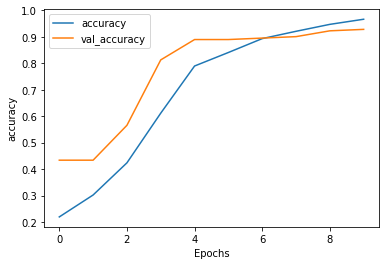

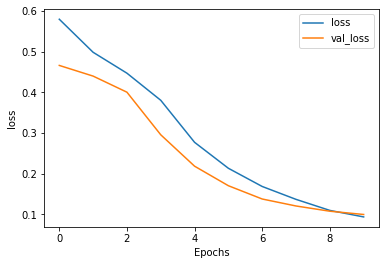

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Predictions on a test set:

In [ ]:
loss, accuracy = model.evaluate([X_test_input_ids, X_test_attention_mask], y_test)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 108ms/step - loss: 0.1000 - accuracy: 0.9286
Test accuracy : 0.9285714030265808


### **Summary**

For our analysis we have used a pretrained Distilbert model to resolve our  text classification problem. After trained model we achieved an accuracy on the test set equal to 93 % and it is a similar result in comparison to previous  models that we have used. We also tested a several models by adding layers and increase numbers of epochs but we do not achaived a better accuracy. 
